In [3]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, concatenate, Add, Activation, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
import json

# Bild- und Maskenpfade laden
image_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testbilder2/'
mask_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testmasken2/'

image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).resize((256, 192))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

def load_and_preprocess_mask_pillow(mask_path):
    mask = Image.open(mask_path).resize((256, 192))
    mask = np.where(np.array(mask) > 128, 1, 0)
    mask = np.expand_dims(mask, axis=-1)
    return mask

X = np.array([load_and_preprocess_image_pillow(path) for path in image_paths])
Y = np.array([load_and_preprocess_mask_pillow(path) for path in mask_paths])

def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

def combined_loss(y_true, y_pred, smooth=1e-6, binary_weight=0.5, dice_weight=0.5):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)
    return binary_weight * bce + dice_weight * dice_loss

def residual_block(x, filters, kernel_size=3):
    shortcut = Conv2D(filters, 1, padding='same')(x)  # Kanäle im Shortcut angleichen
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    return Activation('relu')(Add()([shortcut, x]))


def attention_block(x, filters):
    g = Conv2D(filters, 1, activation='relu', padding='same')(x)
    h = Conv2D(filters, 1, activation='sigmoid', padding='same')(x)
    return Multiply()([g, h])

def rasnet_model(input_size=(192, 256, 1)):
    inputs = Input(input_size)
    x = residual_block(inputs, 64)
    x = attention_block(x, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(x)

    x = residual_block(pool1, 128)
    x = attention_block(x, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(x)

    x = residual_block(pool2, 256)
    x = attention_block(x, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(x)

    bottleneck = Conv2D(512, 3, padding='same', activation='relu')(pool3)
    bottleneck = BatchNormalization()(bottleneck)

    up3 = UpSampling2D(size=(2, 2))(bottleneck)
    up3 = concatenate([up3, x], axis=-1)
    x = residual_block(up3, 256)

    up2 = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(up2)
    x = residual_block(x, 128)

    up1 = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(up1)
    x = residual_block(x, 64)

    outputs = Conv2D(1, 1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_val_loss = float('inf')
best_model_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_rasnet.h5'

epochs = 1000
batch_size = 8

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}/{kf.n_splits}")
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    model = rasnet_model()
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=combined_loss, metrics=[dice_metric])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[early_stopping, reduce_lr], verbose=1)

    if hist.history['val_loss'][-1] < best_val_loss:
        best_val_loss = hist.history['val_loss'][-1]
        model.save(best_model_path)

history_file = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/training_history_rasnet.json'
with open(history_file, 'w') as f:
    json.dump(hist.history, f)

print(f"Bestes Modell wurde unter {best_model_path} gespeichert.")
print(f"Training Historie wurde unter {history_file} gespeichert.")



Fold 1/5
Epoch 1/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 2361s 18s/step - dice_metric: 0.6540 - loss: 0.2816 - val_dice_metric: 0.0361 - val_loss: 0.7401 - learning_rate: 1.0000e-04
Epoch 2/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 2331s 18s/step - dice_metric: 0.8753 - loss: 0.1023 - val_dice_metric: 0.0055 - val_loss: 0.8845 - learning_rate: 1.0000e-04
Epoch 3/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 2330s 18s/step - dice_metric: 0.8912 - loss: 0.0863 - val_dice_metric: 0.0042 - val_loss: 0.9029 - learning_rate: 1.0000e-04
Epoch 4/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 2342s 18s/step - dice_metric: 0.9248 - loss: 0.0628 - val_dice_metric: 0.0359 - val_loss: 0.8508 - learning_rate: 1.0000e-04
Epoch 5/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 2297s 18s/step - dice_metric: 0.9363 - loss: 0.0535 - val_dice_metric: 0.7596 - val_loss: 0.1893 - learning_rate: 1.0000e-04
Epoch 6/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 2336s 18s/step - dice_metric: 0.9312 - loss: 0.0576 - val_dice_metric: 0.8255 - val_loss: 0.1378 - learning_rate:


Fold 2/5
Epoch 1/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1109s 9s/step - dice_metric: 0.5554 - loss: 0.4231 - val_dice_metric: 0.0629 - val_loss: 0.6746 - learning_rate: 1.0000e-04
Epoch 2/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1087s 8s/step - dice_metric: 0.8010 - loss: 0.1503 - val_dice_metric: 0.0239 - val_loss: 0.7545 - learning_rate: 1.0000e-04
Epoch 3/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1097s 9s/step - dice_metric: 0.8575 - loss: 0.1107 - val_dice_metric: 0.0141 - val_loss: 0.7942 - learning_rate: 1.0000e-04
Epoch 4/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1088s 9s/step - dice_metric: 0.8872 - loss: 0.0880 - val_dice_metric: 0.1107 - val_loss: 0.7039 - learning_rate: 1.0000e-04
Epoch 5/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1082s 8s/step - dice_metric: 0.8974 - loss: 0.0798 - val_dice_metric: 0.6566 - val_loss: 0.2594 - learning_rate: 1.0000e-04
Epoch 6/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1084s 8s/step - dice_metric: 0.9221 - loss: 0.0616 - val_dice_metric: 0.8410 - val_loss: 0.1148 - learning_rate: 1.000


Fold 3/5
Epoch 1/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1133s 9s/step - dice_metric: 0.6129 - loss: 0.3446 - val_dice_metric: 0.0451 - val_loss: 0.7195 - learning_rate: 1.0000e-04
Epoch 2/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1108s 9s/step - dice_metric: 0.8365 - loss: 0.1271 - val_dice_metric: 0.0121 - val_loss: 0.8259 - learning_rate: 1.0000e-04
Epoch 3/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1114s 9s/step - dice_metric: 0.8892 - loss: 0.0900 - val_dice_metric: 0.0096 - val_loss: 0.8430 - learning_rate: 1.0000e-04
Epoch 4/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 4992s 39s/step - dice_metric: 0.9073 - loss: 0.0752 - val_dice_metric: 0.0165 - val_loss: 0.8484 - learning_rate: 1.0000e-04
Epoch 5/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 954s 7s/step - dice_metric: 0.9203 - loss: 0.0639 - val_dice_metric: 0.5629 - val_loss: 0.3314 - learning_rate: 1.0000e-04
Epoch 6/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 955s 7s/step - dice_metric: 0.9354 - loss: 0.0530 - val_dice_metric: 0.8534 - val_loss: 0.1068 - learning_rate: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_B8_ch00.tif, Durchmesser (Pixel): 63.030159461153474, Durchmesser (µm): 118.78227762133211
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_D7_ch00.tif, Durchmesser (Pixel): 62.837546770064506, Durchmesser (µm): 118.41929307009642
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_E7_ch00.tif, Durchmesser (Pixel): 64.05055326560611, Durchmesser (µm): 120.70524118670721
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_E8_ch00.tif, Durchmesser (Pixel): 65.66510921894042, Durchmesser (µm): 123.74792162927102
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_F7_ch00.tif, Durchmesser (Pixel): 66.249206645

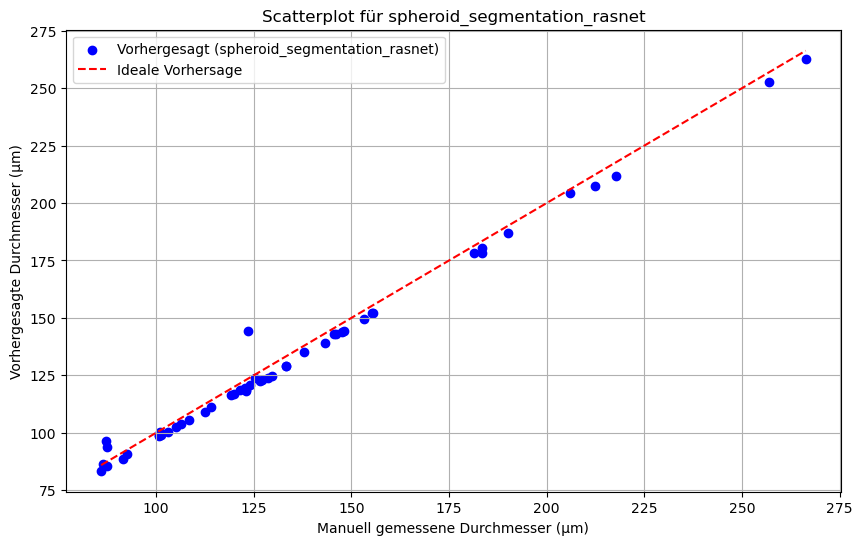

Scatterplot für spheroid_segmentation_rasnet gespeichert unter: C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/scatter_spheroid_segmentation_rasnet.png
Alle Ergebnisse und Scatterplots wurden gespeichert in C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Durchmesser_Liste_Multiple_Modelle.xlsx.
Model: spheroid_segmentation_rasnet, R²: 0.9872, MAE: 3.7692


In [1]:
import os
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model



# Funktionen für Bildbearbeitung und Maskenerstellung
def draw_contours_and_centroid(binary_mask, output_path):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(color_mask, contours, -1, (0, 255, 0), 2)
    
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(color_mask, (cX, cY), 5, (0, 0, 255), -1)
    cv2.imwrite(output_path, color_mask)

# Dice Metric
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Benutzerdefinierte Verlustfunktion
def combined_loss(y_true, y_pred, smooth=1e-6, binary_weight=0.5, dice_weight=0.5):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)
    return binary_weight * bce + dice_weight * dice_loss

# Laden und Vorverarbeiten der Bilder
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((256, 192))
    img = np.array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

# Vorhersage mit dem Modell machen
def predict_with_model(model, image):
    image = np.expand_dims(image, axis=0)
    predicted_mask = model.predict(image)
    return np.squeeze(predicted_mask)

# Funktion zur Berechnung des mittleren Durchmessers
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)

# mit mehreren Modellen vorhersagen und die berechnungen durchführen    
def process_models(model_paths, input_dir, output_dir, excel_file_path, output_excel_path):
    # Excel-Datei laden (manuelle Durchmesser)
    df_manual = pd.read_excel(excel_file_path, header=0)

    # Überprüfen, ob die 'Durchmesser'-Spalte numerische Werte enthält
    df_manual['Durchmesser'] = pd.to_numeric(df_manual['Durchmesser'], errors='coerce')
    df_manual.dropna(subset=['Durchmesser'], inplace=True)

    # Manuelle Durchmesser in eine Liste konvertieren
    manual_diameters = df_manual['Durchmesser'].tolist()

    # Skalierungsfaktoren berechnen
    scale_factor_width = 1296 / 256
    scale_factor_height = 966 / 196

    # TIFF-Dateien laden
    tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

    if len(tif_files) != len(manual_diameters):
        print("Die Anzahl der Bilddateien stimmt nicht mit der Anzahl der manuellen Messungen überein.")
        return

    # Ergebnisse für jedes Modell speichern
    all_predicted_diameters = {}
    metrics = {}

    for model_path in model_paths:
        model_name = os.path.basename(model_path).replace('.h5', '')
        predicted_diameters = []

        # Modell laden und kompilieren (wegen dem custom loss)
        model = load_model(model_path, compile=False)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, binary_weight=0.5, dice_weight=0.5),
                      metrics=[])

        for i, filename in enumerate(tif_files):
            img_path = os.path.join(input_dir, filename)
            try:
                # Bild laden und vorverarbeiten
                image = load_and_preprocess_image_pillow(img_path)
                predicted_mask = predict_with_model(model, image)  # Vorhersage mit dem Modell

                if predicted_mask is None:
                    print(f"Fehler bei der Vorhersage für {filename}.")
                    continue

                contours, _ = cv2.findContours((predicted_mask > 0.5).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                if not contours:
                    print(f"Keine Konturen im Bild {filename} gefunden.")
                    continue

                largest_contour = max(contours, key=cv2.contourArea)
                M = cv2.moments(largest_contour)
                if M["m00"] == 0:
                    print(f"Momentenberechnung ergibt 0 für Bild {filename}.")
                    continue
                center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

                avg_diameter_pixels = calculate_average_diameter(largest_contour, center)
                avg_diameter_micrometers = avg_diameter_pixels * (0.3745 * scale_factor_width) * 0.994

                # Print-Anweisung für die berechneten Durchmesser
                print(f"Bild: {filename}, Durchmesser (Pixel): {avg_diameter_pixels}, Durchmesser (µm): {avg_diameter_micrometers}")

                predicted_diameters.append(avg_diameter_micrometers)

                output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_{model_name}_segmentiert.tif")
                draw_contours_and_centroid((predicted_mask > 0.5).astype(np.uint8) * 255, output_path)

            except Exception as e:
                print(f"Fehler bei der Verarbeitung von {filename}: {e}")

        all_predicted_diameters[model_name] = predicted_diameters

        # Berechnung der Metriken 
        r2 = r2_score(manual_diameters, predicted_diameters)
        mae = mean_absolute_error(manual_diameters, predicted_diameters)
        metrics[model_name] = {'R²': r2, 'MAE': mae}

        print(f"Model: {model_name}, Anzahl der vorhergesagten Durchmesser: {len(predicted_diameters)}, Werte: {predicted_diameters}")

    # Scatterplot für alle Modelle erstellen
    create_scatterplots(manual_diameters, all_predicted_diameters, metrics, output_dir)

    # Ergebnisse in DataFrame konvertieren und exportieren
    df_results = pd.DataFrame(all_predicted_diameters)
    df_results.insert(0, 'Manuell gemessene Durchmesser (µm)', manual_diameters)
    df_results.to_excel(output_excel_path, index=False)

    print(f"Alle Ergebnisse und Scatterplots wurden gespeichert in {output_excel_path}.")

    # Metriken ausgeben
    for model_name, metric in metrics.items():
        print(f"Model: {model_name}, R²: {metric['R²']:.4f}, MAE: {metric['MAE']:.4f}")

# Funktion zum Erstellen von Scatterplots
def create_scatterplots(manual_diameters, all_predicted_diameters, metrics, output_dir):
    for model_name, predicted_diameters in all_predicted_diameters.items():
        plt.figure(figsize=(10, 6))
        plt.scatter(manual_diameters, predicted_diameters, color='blue', label=f'Vorhergesagt ({model_name})')
        plt.plot([min(manual_diameters), max(manual_diameters)], [min(manual_diameters), max(manual_diameters)], color='red', linestyle='--', label='Ideale Vorhersage')
        plt.xlabel('Manuell gemessene Durchmesser (µm)')
        plt.ylabel('Vorhergesagte Durchmesser (µm)')
        plt.title(f'Scatterplot für {model_name}')
        plt.legend()
        plt.grid(True)

        scatter_output_path = os.path.join(output_dir, f'scatter_{model_name}.png')
        plt.savefig(scatter_output_path)
        plt.show()
        plt.close()
        print(f"Scatterplot für {model_name} gespeichert unter: {scatter_output_path}")

model_paths = [

 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_rasnet.h5'
]

input_dir = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testset von julia"
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/'
excel_file_path = 'C:/Users/chris/Documents/Testset.xlsx'
output_excel_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Durchmesser_Liste_Multiple_Modelle.xlsx'

process_models(model_paths, input_dir, output_dir, excel_file_path, output_excel_path)
